In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-dataset/heart.csv
/kaggle/input/health-heart-disease-data/health_data.csv


In [40]:
# Fixed / ready-to-run Kaggle cell
# Full pipeline for health_data CSV (handles directory input automatically)

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import joblib
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# ----------------------------
# Load CSV (handle both file path or folder path)
# ----------------------------
input_path = "/kaggle/input/health-heart-disease-data"  # change if needed

if os.path.isdir(input_path):
    csvs = glob.glob(os.path.join(input_path, "*.csv"))
    if len(csvs) == 0:
        raise FileNotFoundError(f"No CSV found in directory {input_path}")
    csv_file = csvs[0]
else:
    csv_file = input_path

print("Reading:", csv_file)

# yaha se apka section start hota h upper aap logo ka kaam ka nhi h.
# -_-  -_- -_- -_- -_- -_- -_- -_- -_- -_- -_- -_- -_- -_- -_- -_- -_- -_- -_- 
#        --------------         Please Start form          -------------------
#        -----------------            Here               ---------------------
#        -------------------     Upper apka kaam       -----------------------
#                                     Nhi h 
#                        ------------------------------





df = pd.read_csv(csv_file)

# ----------------------------
# 2) Basic EDA
# ----------------------------
print("\n--- Data Head ---")
display(df.head())

print("\n--- Describe ---")
display(df.describe().T)


Reading: /kaggle/input/health-heart-disease-data/health_data.csv

--- Data Head ---


,age,bmi,blood_pressure,cholesterol,glucose,heart_rate,steps_per_day,sleep_hours,smoker,alcohol_intake,exercise_freq,disease_risk
0,56.0,30.489511,118.685426,224.546345,87.192046,69.994022,NaN,8.409396,1.0,1.902807,4.0,0
1,69.0,22.288856,NaN,202.344363,83.654091,77.350452,NaN,4.693069,1.0,NaN,5.0,1
2,46.0,NaN,128.822999,225.283577,84.695553,82.389368,6239.780911,5.759010,1.0,1.804877,NaN,0
3,32.0,NaN,127.630024,168.691356,100.125690,77.305026,6435.523266,9.472247,1.0,4.364901,5.0,0
4,60.0,NaN,155.524296,380.856170,51.316472,80.358211,5546.080014,6.662757,0.0,4.814111,1.0,1



--- Describe ---


,count,mean,std,min,25%,50%,75%,max
age,850.0,49.781176,18.096824,18.000000,35.000000,50.000000,66.000000,79.000000
bmi,850.0,27.424256,11.595032,10.727179,22.595845,25.654102,28.536109,136.924667
blood_pressure,850.0,123.974574,22.147372,76.477145,110.656269,121.604053,132.235707,244.499579
cholesterol,850.0,207.984560,49.959950,86.619680,177.283366,203.253906,228.449762,439.482306
glucose,850.0,100.191196,20.127224,47.018009,87.068415,99.730017,113.386376,173.154036
heart_rate,850.0,71.873581,9.884140,34.912034,65.389721,72.411263,78.627363,100.408864
steps_per_day,850.0,8093.929460,2463.212363,338.857828,6404.436364,8082.024502,9861.161870,16998.666952
sleep_hours,850.0,7.025206,1.510523,2.777928,6.006812,7.040174,8.039234,12.333426
smoker,850.0,0.510588,0.500182,0.000000,0.000000,1.000000,1.000000,1.000000
alcohol_intake,850.0,4.925353,3.049890,-3.736403,2.825687,4.856856,6.959005,14.226757


In [41]:

# if 'disease_risk' not in df.columns:
#     raise KeyError("Target column 'disease_risk' not found in the dataset. Rename the target column to 'disease_risk' or change the code.")

print("\nTarget distribution:")
print(df['disease_risk'].value_counts())





Target distribution:
disease_risk
0    502
1    498
Name: count, dtype: int64



Boxplots for numeric columns (BEFORE imputation).


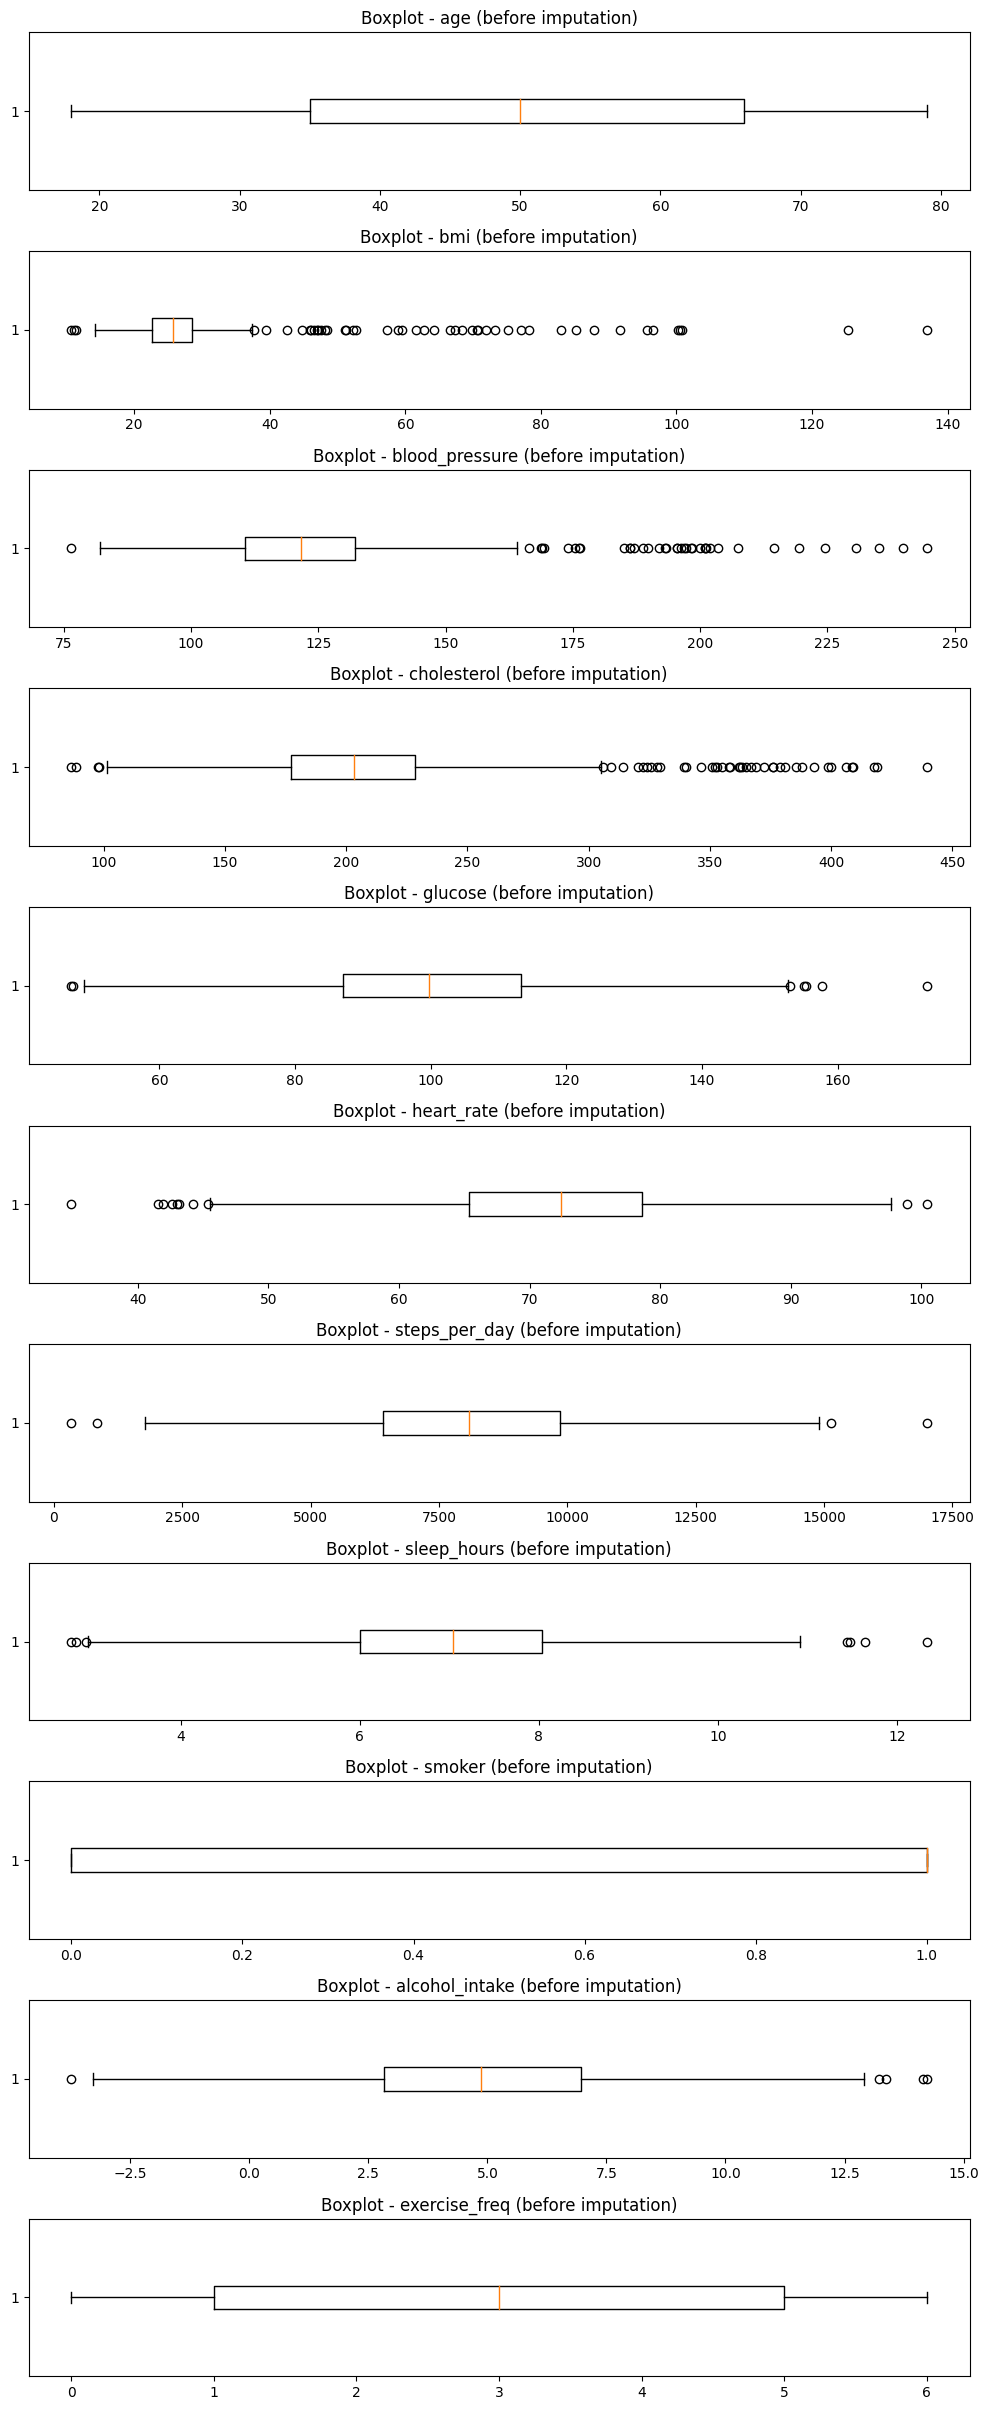

In [42]:
# ----------------------------
# 3) Visualize outliers: boxplot for each numeric column (BEFORE imputation)
# ----------------------------
num_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'disease_risk' in num_cols:
    num_cols.remove('disease_risk')

print("\nBoxplots for numeric columns (BEFORE imputation).")
plt.figure(figsize=(10, len(num_cols)*2.2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f"Boxplot - {col} (before imputation)")
    plt.xlabel("")
plt.tight_layout()
plt.show()



In [43]:
# ----------------------------
# 4) Missing value handling
#    - numeric -> median
#    - categorical -> mode
# ----------------------------
df_imputed = df.copy()
for col in df_imputed.columns:
    if df_imputed[col].isnull().sum() > 0:
        if pd.api.types.is_numeric_dtype(df_imputed[col]):
            med = df_imputed[col].median()
            df_imputed[col].fillna(med, inplace=True)
            print(f"Imputed numeric '{col}' with median = {med:.3f}")
        else:
            mode = df_imputed[col].mode()[0]
            df_imputed[col].fillna(mode, inplace=True)
            print(f"Imputed categorical '{col}' with mode = {mode}")


Imputed numeric 'age' with median = 50.000
Imputed numeric 'bmi' with median = 25.654
Imputed numeric 'blood_pressure' with median = 121.604
Imputed numeric 'cholesterol' with median = 203.254
Imputed numeric 'glucose' with median = 99.730
Imputed numeric 'heart_rate' with median = 72.411
Imputed numeric 'steps_per_day' with median = 8082.025
Imputed numeric 'sleep_hours' with median = 7.040
Imputed numeric 'smoker' with median = 1.000
Imputed numeric 'alcohol_intake' with median = 4.857
Imputed numeric 'exercise_freq' with median = 3.000



Boxplots for numeric columns (AFTER imputation, BEFORE outlier removal).


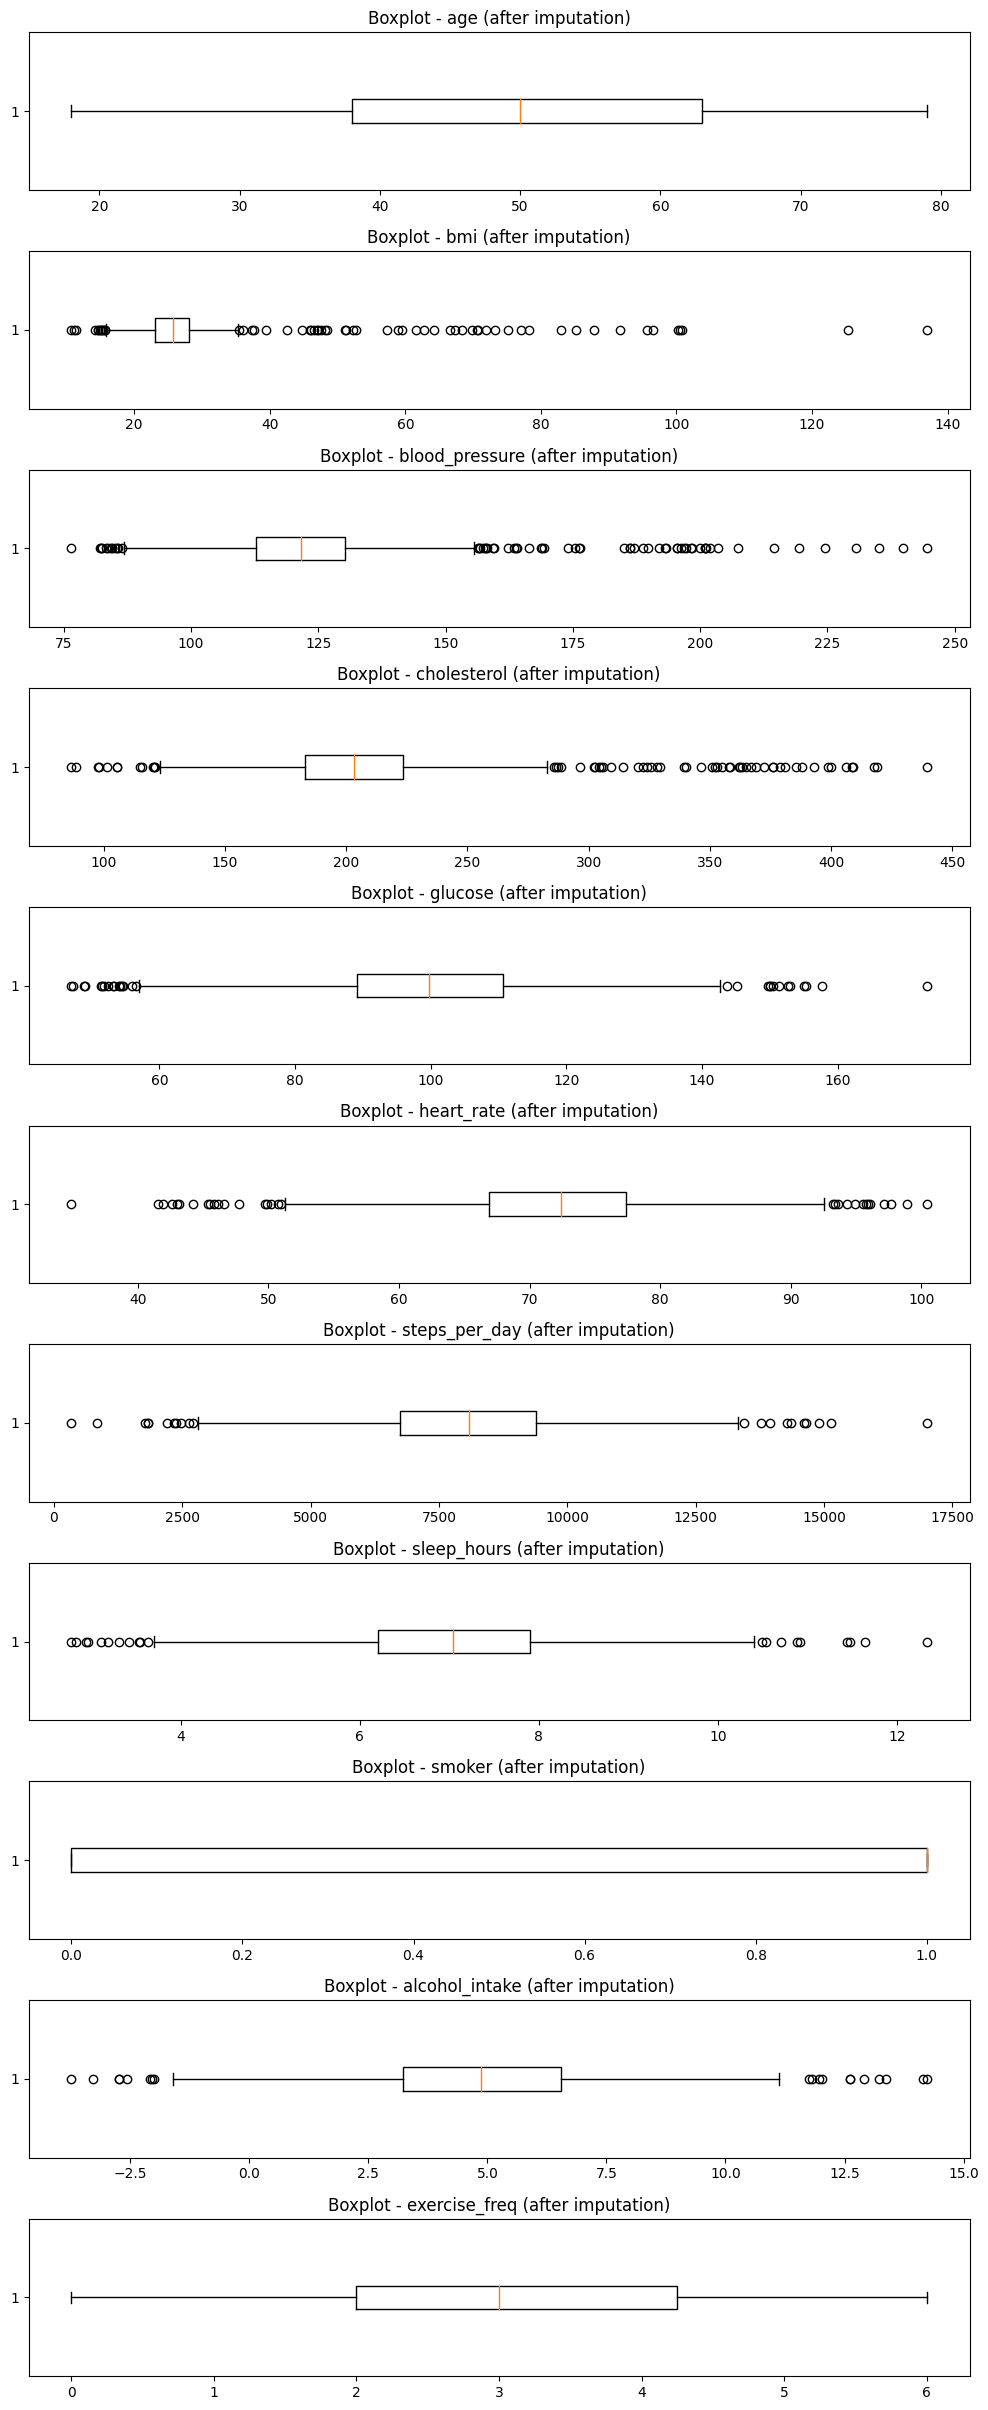

In [44]:

# ----------------------------
# 5) Visualize boxplots AFTER imputation (still before outlier removal)
# ----------------------------
print("\nBoxplots for numeric columns (AFTER imputation, BEFORE outlier removal).")
plt.figure(figsize=(10, len(num_cols)*2.2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    plt.boxplot(df_imputed[col].dropna(), vert=False)
    plt.title(f"Boxplot - {col} (after imputation)")
    plt.xlabel("")
plt.tight_layout()
plt.show()



In [45]:
# ----------------------------
# 6) Outlier removal using IQR (applied column-wise, cumulative)
# ----------------------------
df_no_out = df_imputed.copy()
removed_summary = {}
for col in num_cols:
    Q1 = df_no_out[col].quantile(0.25)
    Q3 = df_no_out[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = df_no_out.shape[0]
    df_no_out = df_no_out[(df_no_out[col] >= lower) & (df_no_out[col] <= upper)]
    after = df_no_out.shape[0]
    removed = before - after
    removed_summary[col] = removed

print("\nOutlier removal summary (rows removed cumulatively per column):")
for k, v in removed_summary.items():
    print(f"{k}: {v} rows removed (cumulative)")

print("\nShape after outlier removal:", df_no_out.shape)




Outlier removal summary (rows removed cumulatively per column):
age: 0 rows removed (cumulative)
bmi: 59 rows removed (cumulative)
blood_pressure: 40 rows removed (cumulative)
cholesterol: 21 rows removed (cumulative)
glucose: 29 rows removed (cumulative)
heart_rate: 25 rows removed (cumulative)
steps_per_day: 20 rows removed (cumulative)
sleep_hours: 16 rows removed (cumulative)
smoker: 0 rows removed (cumulative)
alcohol_intake: 14 rows removed (cumulative)
exercise_freq: 0 rows removed (cumulative)

Shape after outlier removal: (776, 12)



Boxplots for numeric columns (AFTER outlier removal).


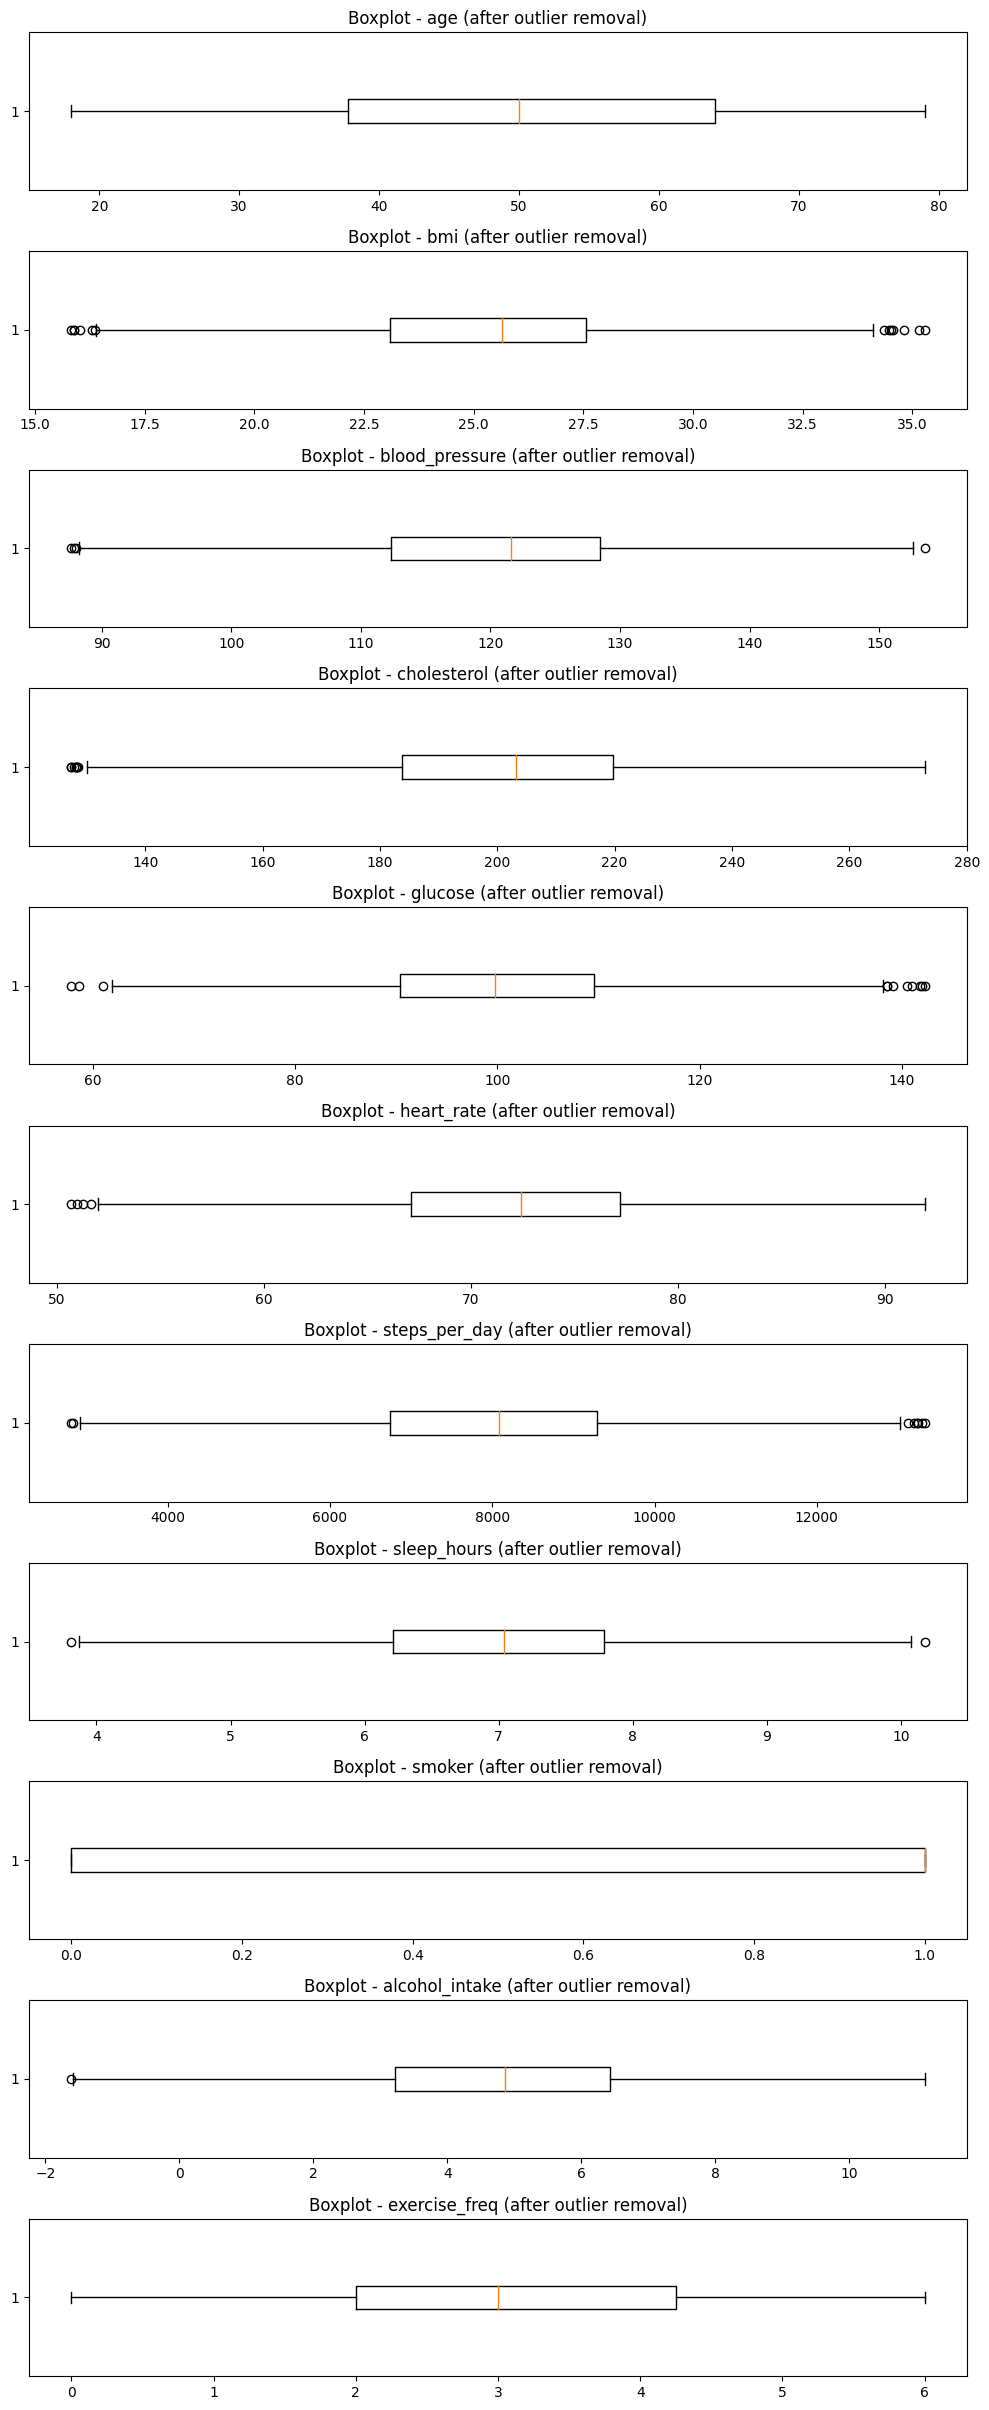


Cleaned dataset saved to: /kaggle/working/health_data_cleaned.csv


In [46]:
# ----------------------------
# 7) Boxplots AFTER outlier removal
# ----------------------------
print("\nBoxplots for numeric columns (AFTER outlier removal).")
plt.figure(figsize=(10, len(num_cols)*2.2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    plt.boxplot(df_no_out[col].dropna(), vert=False)
    plt.title(f"Boxplot - {col} (after outlier removal)")
    plt.xlabel("")
plt.tight_layout()
plt.show()

# Save cleaned dataset to working dir
clean_path = "/kaggle/working/health_data_cleaned.csv"
df_no_out.to_csv(clean_path, index=False)
print("\nCleaned dataset saved to:", clean_path)


In [47]:

# ----------------------------
# 8) Prepare for modeling
# ----------------------------
X = df_no_out.drop('disease_risk', axis=1)
y = df_no_out['disease_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTrain/Test sizes:", X_train.shape[0], X_test.shape[0])
print("Number of features:", X_train.shape[1])



Train/Test sizes: 620 156
Number of features: 11


In [48]:

# ----------------------------
# 9) Random Forest + Fast hyperparameter tuning (RandomizedSearchCV)
# ----------------------------
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100,150,200,250,300],
    'max_depth': [5,8,10,None],
    'min_samples_split': [2,3,4,5,6,8,10],
    'min_samples_leaf': [1,2,3,4],
    'bootstrap': [True, False]
}

rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    scoring='f1'
)

print("\nStarting RandomizedSearchCV .")
rand_search.fit(X_train_scaled, y_train)
best_rf = rand_search.best_estimator_
print("Best params found:", rand_search.best_params_)



Starting RandomizedSearchCV .
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params found: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 5, 'bootstrap': True}



--- Test Metrics ---
Accuracy : 0.5000
Precision: 0.4940
Recall   : 0.5325
F1 Score : 0.5125
AUC      : 0.4965

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.47      0.49        79
           1       0.49      0.53      0.51        77

    accuracy                           0.50       156
   macro avg       0.50      0.50      0.50       156
weighted avg       0.50      0.50      0.50       156



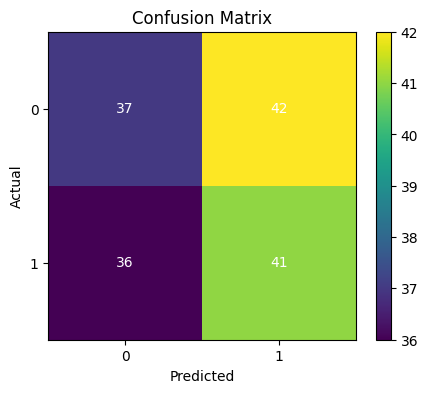

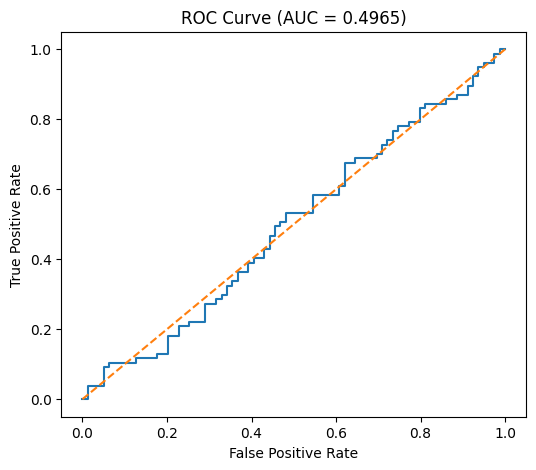


Feature importances (top 12):


alcohol_intake    0.131704
steps_per_day     0.120251
sleep_hours       0.117490
blood_pressure    0.113802
glucose           0.100648
heart_rate        0.098939
bmi               0.093559
cholesterol       0.087686
age               0.087301
exercise_freq     0.040882
smoker            0.007738
dtype: float64


Saved model to /kaggle/working/rf_best_model.joblib and scaler to /kaggle/working/scaler.joblib


In [49]:

# ----------------------------
# 10) Evaluate on Test set
# ----------------------------
y_pred = best_rf.predict(X_test_scaled)
y_proba = best_rf.predict_proba(X_test_scaled)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print("\n--- Test Metrics ---")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1])
plt.yticks([0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center', color='white' if z>cm.max()/2 else 'black')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc:.4f})')
plt.show()

# Feature importances
feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature importances (top 12):")
display(feat_imp.head(12))

# Save final model and scaler
joblib.dump(best_rf, "/kaggle/working/rf_best_model.joblib")
joblib.dump(scaler, "/kaggle/working/scaler.joblib")
print("\nSaved model to /kaggle/working/rf_best_model.joblib and scaler to /kaggle/working/scaler.joblib")